<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/03_02_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing LSTMs using TensorFlow

This notebook walks you through the implementation of an LSTM model to classify news headlines as sarcastic or not_sarcastic. We will analyse the accuracy & loss curves for training and validation sets.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2025-07-18 11:17:52.216288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 11:17:52.441179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 11:17:55.546507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 11:17:57.111698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752837479.357302    2116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752837479.92

2.19.0


## Downloading the Headlines data


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json \
    -o /tmp/headlines.json

In [5]:
import pandas as pd

data = pd.read_json("./Sarcasm_Headlines_Dataset_v2_fixed.json")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

## Data Preparation

In [7]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 150
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000  # define training size(index)

In [8]:
##training set from 0 to training size
training_sentences = headlines[0:20000]
training_labels = labels[0:20000]

##testing set from training size to the end
testing_sentences = headlines[20000:]
testing_labels = labels[20000:]

In [9]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Define the LSTM model with the following layers:
1. Embedding layer
2. Add two bidirectional LSTM layers with 64 and 32 as number of outputs.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
num_epochs = 10
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    verbose=2)

Epoch 1/10
625/625 - 88s - 141ms/step - accuracy: 0.7951 - loss: 0.4211 - val_accuracy: 0.8496 - val_loss: 0.3375
Epoch 2/10
625/625 - 83s - 133ms/step - accuracy: 0.9016 - loss: 0.2481 - val_accuracy: 0.8470 - val_loss: 0.3734
Epoch 3/10
625/625 - 81s - 130ms/step - accuracy: 0.9452 - loss: 0.1469 - val_accuracy: 0.8521 - val_loss: 0.3924
Epoch 4/10
625/625 - 83s - 134ms/step - accuracy: 0.9681 - loss: 0.0925 - val_accuracy: 0.8467 - val_loss: 0.4929
Epoch 5/10
625/625 - 81s - 130ms/step - accuracy: 0.9821 - loss: 0.0560 - val_accuracy: 0.8398 - val_loss: 0.5512
Epoch 6/10
625/625 - 80s - 129ms/step - accuracy: 0.9804 - loss: 0.0609 - val_accuracy: 0.8397 - val_loss: 0.5249
Epoch 7/10
625/625 - 84s - 135ms/step - accuracy: 0.9858 - loss: 0.0424 - val_accuracy: 0.8365 - val_loss: 0.6548
Epoch 8/10
625/625 - 82s - 131ms/step - accuracy: 0.9926 - loss: 0.0241 - val_accuracy: 0.8379 - val_loss: 0.7589
Epoch 9/10
625/625 - 86s - 137ms/step - accuracy: 0.9943 - loss: 0.0170 - val_accuracy: 

## Visualize accuracy and loss

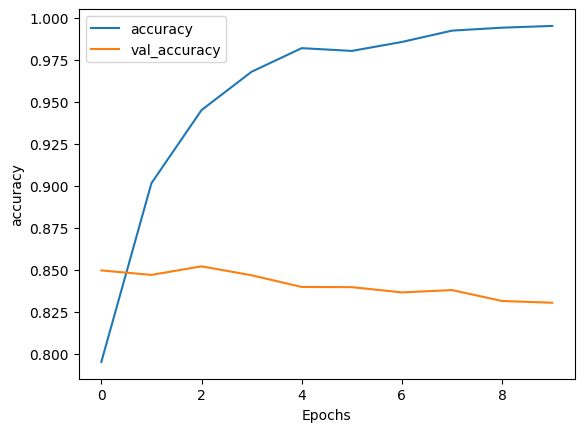

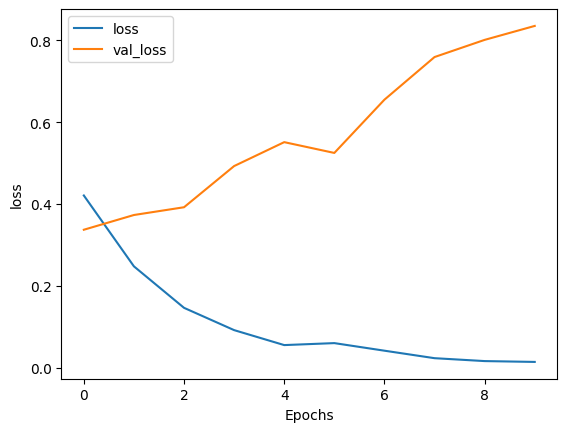

In [17]:
import matplotlib.pyplot as plt


def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

## Classifying unseen headlines

In [18]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[[8.1810824e-05]
 [1.2131194e-04]]
